In [16]:
from replenishment import (
    PercentileForecastOptimizationPolicy,
    build_percentile_forecast_candidates_from_standard_rows,
    build_point_forecast_article_configs_from_standard_rows,
    build_replenishment_decisions_from_simulations,
    evaluate_aggregation_and_forecast_target_costs,
    evaluate_aggregation_and_service_level_factor_costs,
    evaluate_forecast_target_costs,
    evaluate_service_level_factor_costs,
    generate_standard_simulation_rows,
    optimize_aggregation_and_forecast_targets,
    optimize_aggregation_and_service_level_factors,
    optimize_forecast_targets,
    optimize_service_level_factors,
    optimize_point_forecast_policy_and_simulate_actuals,
    plot_replenishment_decisions,
    replenishment_decision_rows_to_dataframe,
    split_standard_simulation_rows,
    simulate_replenishment_with_aggregation,
    standard_simulation_rows_to_dataframe,
    standard_simulation_rows_from_dataframe,
)


In [17]:
rows = generate_standard_simulation_rows(
    n_unique_ids=1,
    periods=115,
    history_mean=18,
    history_std=4,
    forecast_mean=10,
    forecast_std=2,
    seed=7,
    percentile_multipliers={
        "p10": 0.8,
        "p25": 0.9,
        "p50": 1.0,
        "p75": 1.1,
        "p90": 1.25,
    },
)
df = standard_simulation_rows_to_dataframe(rows, library="pandas")


In [18]:
df["current_stock"] = 10

# Drop is_forecast so the cutoff defines the backtest/evaluation split.
df = df.drop(columns=["is_forecast"])

cutoff_period = 80
cutoff = sorted(df["ds"].unique())[cutoff_period - 1]
rows = standard_simulation_rows_from_dataframe(df, cutoff=cutoff)


In [19]:
import pandas as pd

backtest_rows, forecast_rows = split_standard_simulation_rows(rows)

backtest_actuals = {}
for row in backtest_rows:
    backtest_actuals.setdefault(row.unique_id, []).append(row)
for unique_id, series in backtest_actuals.items():
    series.sort(key=lambda r: r.ds)
    backtest_actuals[unique_id] = [int(r.actuals) for r in series]
point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=0.9,
)

sigma_costs = evaluate_service_level_factor_costs(
    point_configs,
    candidate_factors=[0.8, 0.9, 0.95, 0.99],
)
sigma_cost_rows = [
    {"unique_id": uid, "service_level_factor": factor, "total_cost": cost}
    for uid, factors in sigma_costs.items()
    for factor, cost in factors.items()
]
sigma_cost_df = pd.DataFrame(sigma_cost_rows)
sigma_cost_df


,unique_id,service_level_factor,total_cost
0,A,0.80,2744.0
1,A,0.90,2137.0
2,A,0.95,2508.0
3,A,0.99,3380.5


In [20]:
optimized, mean_forecast_simulations, mean_decision_rows = (
    optimize_point_forecast_policy_and_simulate_actuals(
        backtest_rows,
        forecast_rows,
        candidate_factors=[0.8, 0.9, 0.95, 0.99],
    )
)
best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in optimized.items()
}
mean_decision_df = replenishment_decision_rows_to_dataframe(
    mean_decision_rows,
    library="pandas",
)
mean_decision_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,incoming_stock,starting_on_hand,ending_on_hand,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2030-07-28,8,12,12,0,10,0,8,2,2,0.9,1,None
1,A,2030-08-27,10,8,8,8,6,0,10,2,2,0.9,1,None
2,A,2030-09-26,12,10,10,10,8,0,12,2,2,0.9,1,None
3,A,2030-10-26,12,12,12,12,10,0,12,2,2,0.9,1,None
4,A,2030-11-25,13,12,12,12,10,0,13,2,2,0.9,1,None


<Axes: title={'center': 'Mean forecast decisions (no aggregation)'}, xlabel='Date', ylabel='Units'>

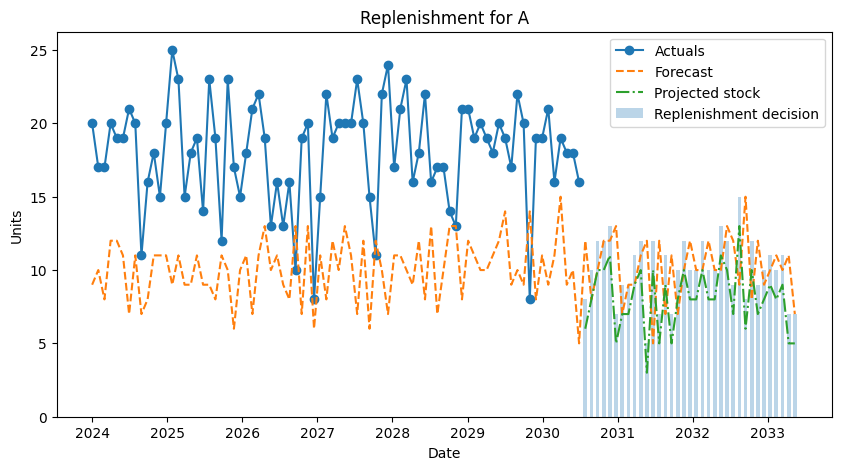

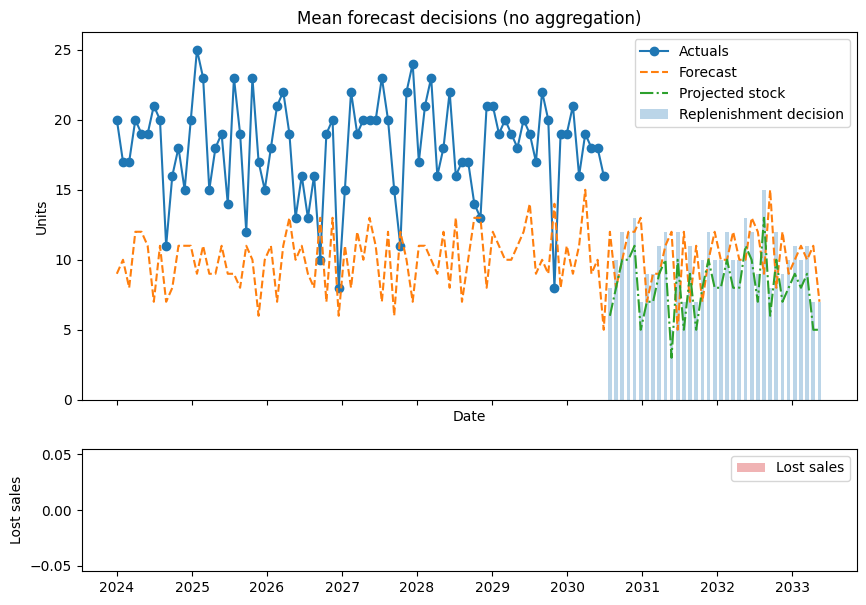

In [21]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, mean_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    mean_decision_df,
    aggregate=True,
    title="Mean forecast decisions (no aggregation)",
)


In [22]:
agg_sigma_costs = evaluate_aggregation_and_service_level_factor_costs(
    point_configs,
    candidate_windows=[1, 2, 3],
    candidate_factors=[0.8, 0.9, 0.95, 0.99],
)
agg_sigma_cost_rows = [
    {
        "unique_id": uid,
        "window": window,
        "service_level_factor": factor,
        "total_cost": cost,
    }
    for uid, window_costs in agg_sigma_costs.items()
    for window, factors in window_costs.items()
    for factor, cost in factors.items()
]
agg_sigma_cost_df = pd.DataFrame(agg_sigma_cost_rows)

agg_sigma_result = optimize_aggregation_and_service_level_factors(
    point_configs,
    candidate_windows=[1, 2, 3],
    candidate_factors=[0.8, 0.9, 0.95, 0.99],
)
agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in agg_sigma_result.items()
}
agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_sigma_result.items()
}
forecast_point_configs = build_point_forecast_article_configs_from_standard_rows(
    forecast_rows,
    service_level_factor=agg_best_factors,
    actuals_override=backtest_actuals,
)
agg_mean_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in forecast_point_configs.items()
}
agg_mean_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    agg_mean_simulations,
)
agg_mean_decision_df = replenishment_decision_rows_to_dataframe(
    agg_mean_decision_rows,
    library="pandas",
)
agg_sigma_cost_df


,unique_id,window,service_level_factor,total_cost
0,A,1,0.80,2744.0
1,A,1,0.90,2137.0
2,A,1,0.95,2508.0
3,A,1,0.99,3380.5
4,A,2,0.80,4595.0
5,A,2,0.90,3131.0
6,A,2,0.95,1752.5
7,A,2,0.99,1609.0
8,A,3,0.80,4546.5
9,A,3,0.90,4390.5


In [23]:
percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    backtest_rows,
    include_mean=True,
)
percentile_costs = evaluate_forecast_target_costs(percentile_configs)
percentile_cost_rows = [
    {"unique_id": uid, "target": target, "total_cost": cost}
    for uid, targets in percentile_costs.items()
    for target, cost in targets.items()
]
percentile_cost_df = pd.DataFrame(percentile_cost_rows)

percentile_result = optimize_forecast_targets(percentile_configs)

forecast_percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    include_mean=True,
)
forecast_percentile_simulations = {}
for unique_id, config in forecast_percentile_configs.items():
    target = percentile_result[unique_id].target
    policy = PercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[target],
        lead_time=config.lead_time,
    )
    forecast_percentile_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=1,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )

percentile_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    forecast_percentile_simulations,
    percentile_target={
        uid: percentile_result[uid].target
        for uid in forecast_percentile_simulations
    },
)
percentile_decision_df = replenishment_decision_rows_to_dataframe(
    percentile_decision_rows,
    library="pandas",
)

percentile_cost_df


,unique_id,target,total_cost
0,A,p10,5211.5
1,A,p25,5197.0
2,A,p50,5182.5
3,A,p75,5162.0
4,A,p90,5117.5
5,A,mean,5182.5


In [24]:
agg_mean_decision_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,incoming_stock,starting_on_hand,ending_on_hand,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2030-07-28,22,20,20,0,10,0,22,10,10,0.99,2,None
1,A,2030-09-26,25,22,22,22,12,0,25,10,10,0.99,2,None
2,A,2030-11-25,16,25,25,25,15,0,16,10,10,0.99,2,None
3,A,2031-01-24,20,16,16,16,6,0,20,10,10,0.99,2,None
4,A,2031-03-25,17,20,20,20,10,0,17,10,10,0.99,2,None


<Axes: title={'center': 'Percentile decisions (no aggregation)'}, xlabel='Date', ylabel='Units'>

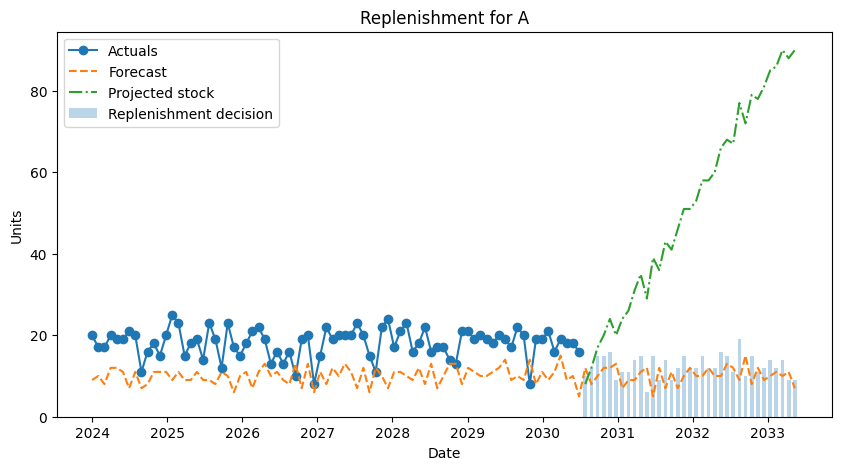

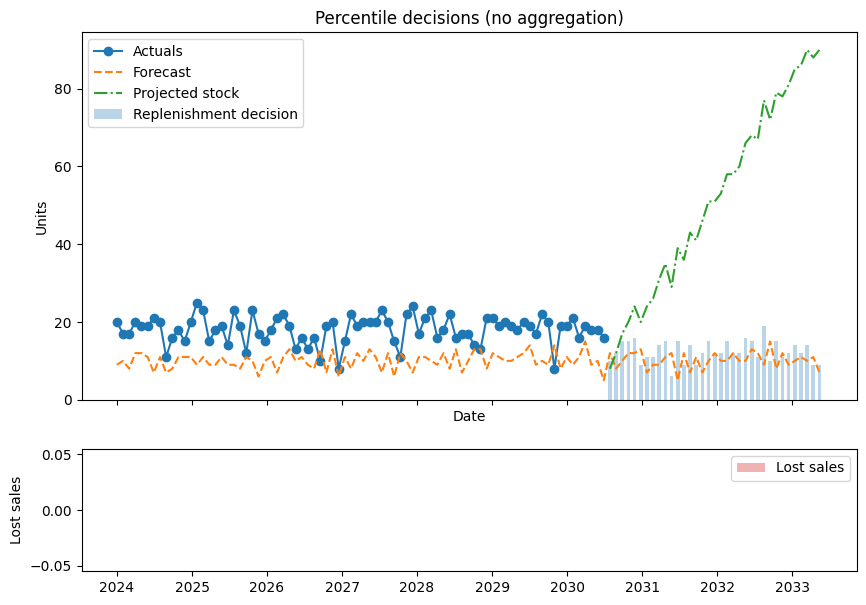

In [25]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, percentile_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    percentile_decision_df,
    aggregate=True,
    title="Percentile decisions (no aggregation)",
)


In [26]:
percentile_backtest_configs = build_percentile_forecast_candidates_from_standard_rows(
    backtest_rows,
    include_mean=True,
)
agg_percentile_costs = evaluate_aggregation_and_forecast_target_costs(
    percentile_backtest_configs,
    candidate_windows=[7, 14, 28],
)
agg_percentile_cost_rows = [
    {
        "unique_id": uid,
        "window": window,
        "target": target,
        "total_cost": cost,
    }
    for uid, window_costs in agg_percentile_costs.items()
    for window, targets in window_costs.items()
    for target, cost in targets.items()
]
agg_percentile_cost_df = pd.DataFrame(agg_percentile_cost_rows)

agg_percentile_results = optimize_aggregation_and_forecast_targets(
    percentile_backtest_configs,
    candidate_windows=[5, 10],
)

forecast_percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    include_mean=True,
)
forecast_percentile_simulations = {}
for unique_id, config in forecast_percentile_configs.items():
    choice = agg_percentile_results[unique_id]
    policy = PercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[choice.target],
        lead_time=config.lead_time,
    )
    forecast_percentile_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=choice.window,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )

agg_percentile_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    forecast_percentile_simulations,
    aggregation_window={
        uid: agg_percentile_results[uid].window
        for uid in forecast_percentile_simulations
    },
    percentile_target={
        uid: agg_percentile_results[uid].target
        for uid in forecast_percentile_simulations
    },
)
agg_percentile_decision_df = replenishment_decision_rows_to_dataframe(
    agg_percentile_decision_rows,
    library="pandas",
)

agg_percentile_cost_df


,unique_id,window,target,total_cost
0,A,7,p10,4398.0
1,A,7,p25,4398.0
2,A,7,p50,4398.0
3,A,7,p75,4398.0
4,A,7,p90,4398.0
5,A,7,mean,4398.0
6,A,14,p10,4323.0
7,A,14,p25,4323.0
8,A,14,p50,4323.0
9,A,14,p75,4323.0


In [27]:
agg_percentile_decision_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,incoming_stock,starting_on_hand,ending_on_hand,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2030-07-28,79,103,83,0,10,0,79,93,73,None,10,p10
1,A,2031-05-24,88,96,79,79,0,0,88,110,79,None,10,p10
2,A,2032-03-19,40,110,88,88,0,0,40,132,88,None,10,p10
3,A,2033-01-13,40,49,40,40,0,0,40,141,40,None,10,p10


<Axes: title={'center': 'Percentile decisions (optimized aggregation)'}, xlabel='Date', ylabel='Units'>

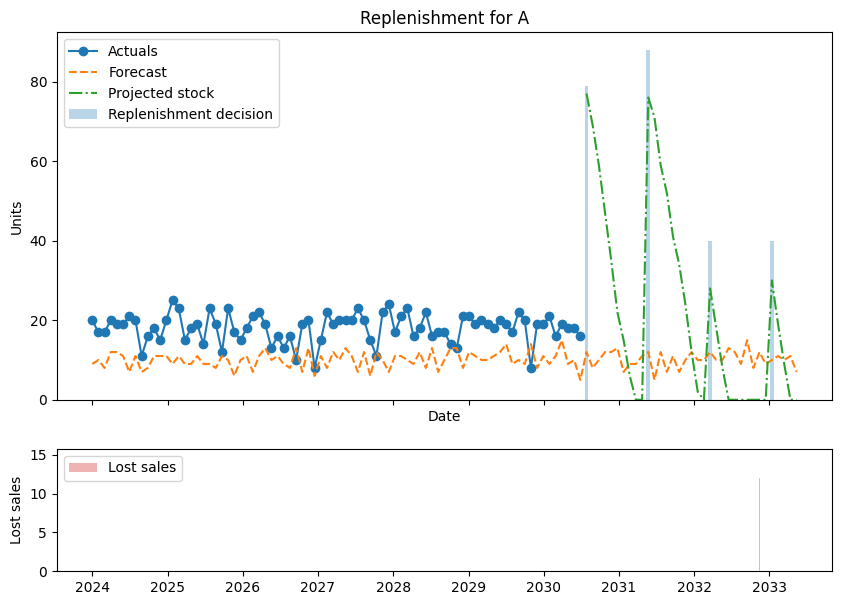

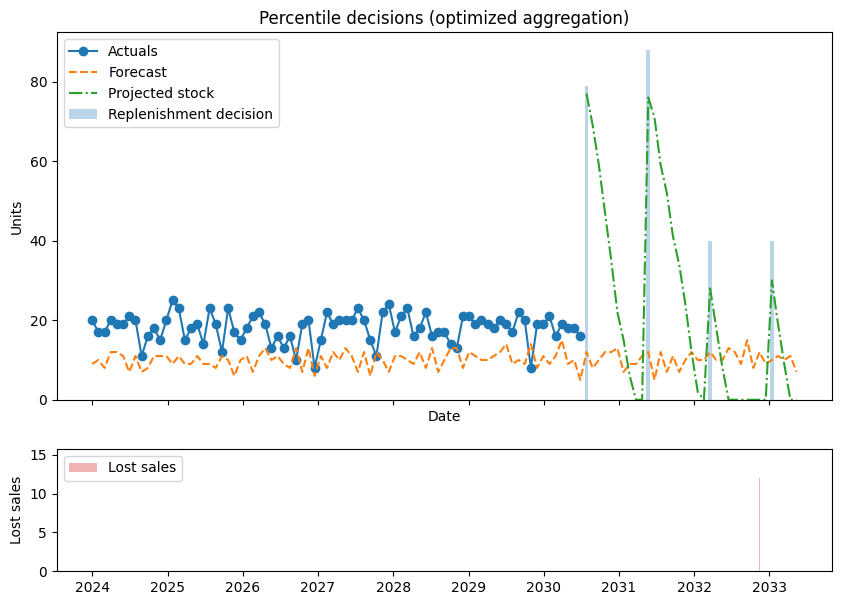

In [28]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, agg_percentile_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    agg_percentile_decision_df,
    aggregate=True,
    title="Percentile decisions (optimized aggregation)",
)


In [30]:
agg_percentile_cost_df


,unique_id,window,target,total_cost
0,A,7,p10,4398.0
1,A,7,p25,4398.0
2,A,7,p50,4398.0
3,A,7,p75,4398.0
4,A,7,p90,4398.0
5,A,7,mean,4398.0
6,A,14,p10,4323.0
7,A,14,p25,4323.0
8,A,14,p50,4323.0
9,A,14,p75,4323.0
